# Functionality:

## Import Packages 

In [1]:
import os, sys
import numpy as np
import glob
import scipy.io as sio
import pandas as pd

from numpy.fft import fft, fftfreq
from scipy.signal import spectrogram

import matplotlib.pyplot as plt

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import animal_folder function in util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb


## exp subfolders

In [3]:
_, _, pipelinefolder, _= exp_subfolders()


## code_corresfolder

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder = code_corresfolder(os.getcwd(), nb_name)

## global parameters

In [6]:
epochfolder = os.path.join(pipelinefolder, 'NHP_Pinky', '0_dataPrep', 'STKtrialextract_0')
savefolder = corresfolder

In [7]:
# trial selection based on reach time and return time
criteria_reachtime = np.array([0.45, 0.8])
criteria_returntime = np.array([0.5, 0.75])

In [8]:
# analyzed frequency range [1 100]Hz
freqs = np.asarray([i for i in range(1, 101)])

## extract Channel Information

load channel information from pipeline/1_dataAnaly/FCAnaly/1_simulatedLocs

In [9]:
## load channel information ##
chnInf_folder = os.path.join(pipelinefolder,'NHP_Pinky','1_dataAnaly','FCAnaly', '1_simulatedLocs_M1ThaSMA')

chnInf_file = os.path.join(chnInf_folder, 'chn_brainArea_simCoord_M1ThaSMA.csv')

df = pd.read_csv(chnInf_file, header = 0)

In [10]:
# channel matchni and recording chni 
chnInf_matchni, chnInf_recchni = df['mat_chni'], df['recording_chni']

chnInf_brainarea = df['brainarea']

x, y = df['simulated_x'].to_numpy(), df['simulated_y'].to_numpy()
chnInf_coord = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)), axis = 1)




#########################  
# Remove nonused channels 
#########################

# extract the indices in which the corresponding channels are not used
idx_mask = ~chnInf_brainarea.isnull()
idx_notused = [i for i, isnan in enumerate(idx_mask) if isnan == False]

chnInf_matchni = chnInf_matchni[idx_mask].to_numpy()

chnInf_recchni = chnInf_recchni[idx_mask].to_numpy()

chnInf_brainarea = chnInf_brainarea[idx_mask].tolist()

chnInf_coord = chnInf_coord[idx_mask]

In [11]:
# extract the channel number of M1 in mat data
chnsmat_M1 = list()
for i, brainarea in enumerate(chnInf_brainarea):
    if brainarea == 'M1':
        chnsmat_M1.append(chnInf_matchni[i])

## Power Calculation

### power_1file()

In [26]:
def power_1file(filename, chns, freqs, criteria_reachtime, criteria_returntime):
    """ 
    
        calculate the power of one file, trials selection based on reach time and return time, 
                    one trial is extract as [t_targeton - 0.2, t_mouth]s
        
        Args:
        
            filename: file name 
            
            chns: channel number, <class 'numpy.ndarray'>, shape = (nchns, )
            
            freqs: frequencies at which power will be calcualted, <class 'numpy.ndarray'>, shape = (nfreqs, )
            
            criteria_reachtime (np.ndarray): the trial selection criteria of reach time, 
                                            e.g criteria_reachtime = np.array([0.45, 0.8])
            
            criteria_returntime (np.nadrray): the trial selection criteria of reach time, 
                                            e.g. criteria_returntime = np.array([0.5, 0.75])
            
            
        Return:
            freqs_powers: calculated powers at freqs, shape = (nfreqs, 2), one sample = [freq, power]
            
    """
    
    ### load mat file and extract data ###
    dat = sio.loadmat(filename, 
                      variable_names = ['idxevent', 'fs', 'lfptrial', 'idxevent_varNames'], 
                      squeeze_me = True,
                      mat_dtype = True)


    # extract idxevent: numpy.ndarray(shape = (ntrials, 5)), idxevent_varNames: numpy.ndarray(nshape = (5,))
    idxevent, idxevent_varNames = dat['idxevent'], dat['idxevent_varNames']
    # extract fs
    fs = dat['fs']
    # extract lfp trial: nchns * ntemporals * ntrials
    lfptrial = dat['lfptrial']

    
    
    
    ### extract the column index of each event and the phase ###
    coli_targeton = np.squeeze(np.where(idxevent_varNames == 'TargetTime'))
    coli_reachon = np.squeeze(np.where(idxevent_varNames == 'ReachTimeix'))
    coli_touch = np.squeeze(np.where(idxevent_varNames == 'TouchTimeix'))
    coli_returnon = np.squeeze(np.where(idxevent_varNames == 'ReturnTimeix'))
    coli_mouth = np.squeeze(np.where(idxevent_varNames == 'MouthTimeix'))

    # column indices of reach and return phases
    cols_reachphase = [coli_reachon] + [coli_touch]
    cols_returnphase = [coli_returnon] + [coli_mouth]
    
    
    
    
    ### calculate the power of each frequency in freqs from all the trials ###
    ntrials, _= idxevent.shape
    # dictionary powers_dict for storing power of each frequency
    powers_dict = dict()
    for triali in range(ntrials):
        
        ### remove the trials with reach time or return time not in criteria ###
        # reach time, and return time
        reachtime = (int(idxevent[triali, cols_reachphase[1]]) - int(idxevent[triali, cols_reachphase[0]]))/fs
        returntime = (int(idxevent[triali, cols_returnphase[1]]) - int(idxevent[triali, cols_returnphase[0]]))/fs

        # if reach time is not in criteria_reachtime
        if(not(criteria_reachtime[0]<reachtime<criteria_reachtime[1])):
            continue;
        # if return time is not in criteria_returntime
        if (not(criteria_returntime[0]<returntime<criteria_returntime[1])):
            continue;
           
            
        
        ### data extraction part ###
        # start and end indices over time of specific phase for triali [t_targeton - 0.2, t_mouth]s
        idxtime_str, idxtime_end = int(idxevent[triali, coli_reachon]), int(idxevent[triali, coli_mouth])

        # extract lfp data of chns for time frequency analysis: shape = (nchns, ntemporals)
        lfp = lfptrial[chns, idxtime_str:idxtime_end, triali]

        # average across all the channels: shape = (ntemporals,)
        avglfp = np.mean(lfp, axis = 0)

        
        
        ### power calculation part ###
        # nfft: the length for fft
        nfft = len(avglfp)

        # fft
        fft_lfp = fft(avglfp)

        # power
        power_lfp = np.square(np.abs(fft_lfp))/nfft

        # sample frequencies of Discrete Fourier Transform 
        freqs_fft = fftfreq(nfft, 1/fs)

        # ignore the negative frequencies
        mask_f = freqs_fft > 0
        freqs_fft = freqs_fft[mask_f]
        power_lfp = power_lfp[mask_f]
        

        
        ### round power to the nearest frequency in freqs_all ### 
        # index of the nearest frequency for all the frequency in freqs
        idx_round = [np.abs(freqs - freq_fft).argmin() for freq_fft in freqs_fft if freq_fft <= freqs[-1] + 0.5]

        # add power of each nearest frequency into dictionary powers_dict
        for idx in idx_round:
            if idx in powers_dict.keys():
                powers_dict[idx] = powers_dict[idx] + [power_lfp[idx]]
            else:
                powers_dict[idx] = [power_lfp[idx]]
    
    
        
        ### delete temporal variables ###
        del reachtime, returntime
        del idxtime_str, idxtime_end, lfp, avglfp
        del nfft, fft_lfp, power_lfp, freqs_fft, mask_f
        del idx_round, idx
    
    
    

    ### power average across all trials ###
    freqs_powers = np.empty(shape=[0,2])
    for idx, freq in enumerate(freqs):

        if idx in powers_dict.keys():

            # calculate the mean power
            power = np.mean(powers_dict[idx])

        else:
            # no power for freq
            power = -1

        newentry = np.expand_dims(np.array([freq, power]), axis = 0)

        # add to powers_freqs
        freqs_powers = np.append(freqs_powers, newentry, axis = 0)

        del power, newentry

    freqs_powers = np.asarray(freqs_powers)
    
    return freqs_powers

### power_allfiles()

In [27]:
def power_allfiles(epochfolder, condition, freqs, chns, criteria_reachtime, criteria_returntime):
    
    """ 
    
        return the mean power of all file in one condition ('mild' or 'normal') in the datfolder
        
        Args:
        
            epochfolder: epoch data folder
            
            condition: 'mild' or 'normal'
            
            freqs_all: frequencies at which power will be calcualted, <class 'numpy.ndarray'>, shape = (nfreqs, )
            
        Return:
            powers_allfiles (np.ndarray): calculated powers at freqs of all files, shape = (nfreqs, nfiles)
            
            avgpower_allfiles (np.ndarray): calculated average powers at freqs, shape = (nfreqs,)
            
    
    
    """

    # condition file pattern
    filepatt = os.path.join(epochfolder, "*" + condition + "*.mat") 

    # extract all .mat files in normal in epoch folder
    files = glob.glob(filepatt)
    
    nfreqs, nfiles = len(freqs), len(files)
    
    # powers_freqs_allfiles store the powers of all files, shape = (nfreqs, nfiles) 
    powers_allfiles = np.zeros((nfreqs, nfiles))
    
    # add power_freqs of each file into powers_freqs_allfiles
    for filei, filename in enumerate(files):
        
        # the power of one file, freqs_powers: (nfreqs, 2)
        freqs_powers = power_1file(filename, chns, freqs, criteria_reachtime, criteria_returntime) 
        
        # assign to power_allfiles
        powers_allfiles[:,0] = freqs_powers[:,1]
        
        del freqs_powers
     
    
    # average across all files
    avgpower_allfiles = np.zeros((nfreqs))
    for freqi in range(nfreqs):
        
        powers = powers_allfiles[freqi]
        
        # ignore the power of value -1
        powers = powers[powers != -1]
        
        
        avgpower_allfiles[freqi] = np.mean(powers) 
        
        del powers
    
    
    # return
    return powers_allfiles, avgpower_allfiles

In [28]:
# powers of all the files and the averaged power in normal condition
condition = 'normal'
powers_normal, avgpower_normal = power_allfiles(epochfolder = epochfolder, condition = condition, freqs = freqs, chns = chnsmat_M1, criteria_reachtime = criteria_reachtime, criteria_returntime = criteria_reachtime)

In [29]:
# powers of all the files and the averaged power in mild condition
condition = 'mild'
powers_mild, avgpower_mild = power_allfiles(epochfolder = epochfolder, condition = condition, freqs = freqs, chns = chnsmat_M1, criteria_reachtime = criteria_reachtime, criteria_returntime = criteria_reachtime)

## Plot

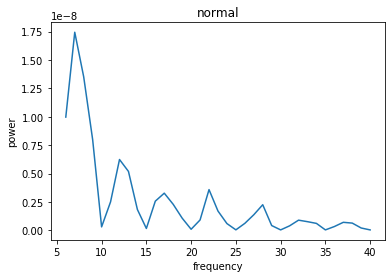

In [30]:
logpower = np.log2(avgpower_normal)
condition = 'normal'
plt.plot(freqs[5:40,], avgpower_normal[5:40,])
plt.xlabel('frequency')
plt.ylabel('power')
plt.title(condition)
plt.savefig(os.path.join(savefolder, 'powerSpectral_' + condition + '.png'))

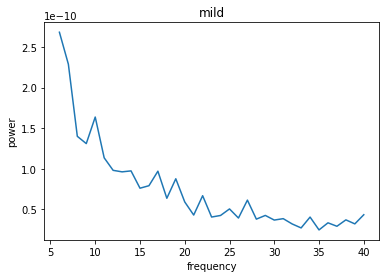

In [31]:
logpower = np.log10(avgpower_mild)
condition = 'mild'
plt.plot(freqs[5:40,], avgpower_mild[5:40,])
plt.xlabel('frequency')
plt.ylabel('power')
plt.title(condition)
plt.savefig(os.path.join(savefolder, 'powerSpectral_' + condition + '.png'))